In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
import importlib

import endoutbreakvbd
import endoutbreakvbd.chikungunya
import endoutbreakvbd.eop
import endoutbreakvbd.inference
import endoutbreakvbd.model
import endoutbreakvbd.utils

importlib.reload(endoutbreakvbd)
importlib.reload(endoutbreakvbd.chikungunya)
importlib.reload(endoutbreakvbd.eop)
importlib.reload(endoutbreakvbd.inference)
importlib.reload(endoutbreakvbd.model)
importlib.reload(endoutbreakvbd.utils)

from endoutbreakvbd import eop_analytical, eop_simulation, renewal_model
from endoutbreakvbd.chikungunya import get_parameters, get_weather_data
from endoutbreakvbd.utils import month_start_xticks

In [3]:
parameters = get_parameters()
gen_time_dist_vec = parameters["gen_time_dist_vec"]
df_weather = get_weather_data()

rng = np.random.default_rng(2)

In [4]:
suitability_vec_all = df_weather["suitability_smoothed"].to_numpy()
doy_vec_all = np.arange(1, 366)

rep_no_factor = 2.5
rep_no_vec_all = rep_no_factor * suitability_vec_all


def rep_no_func_doy(doy):
    return np.interp(doy, doy_vec_all, rep_no_vec_all, period=365)

Text(0, 0.5, 'Time-dependent reproduction number')

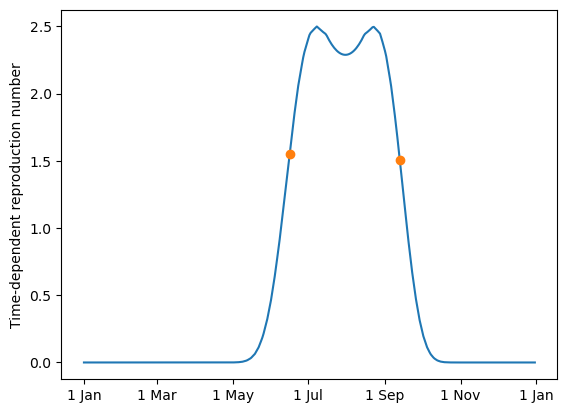

In [16]:
example_doys = [
    (rep_no_vec_all > 1.5).nonzero()[0][0] + 1,
    (rep_no_vec_all > 1.5).nonzero()[0][-1] + 1,
]

fig, ax = plt.subplots()
doy_vec = np.arange(1, 366)
ax.plot(doy_vec, rep_no_func_doy(doy_vec))
ax.plot(example_doys, rep_no_func_doy(np.array(example_doys)), "o")
month_start_xticks(ax)
ax.set_ylabel("Time-dependent reproduction number")

100%|██████████| 56/56 [00:18<00:00,  2.98it/s]


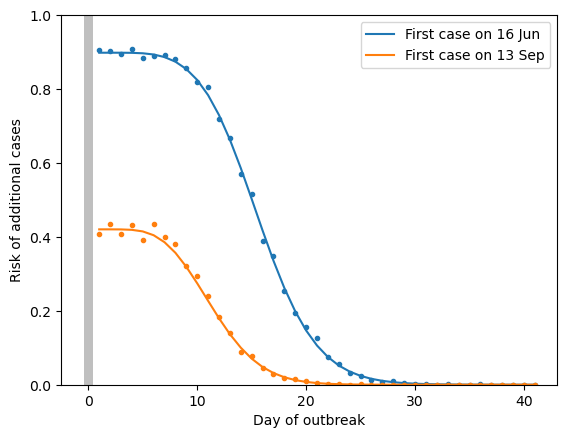

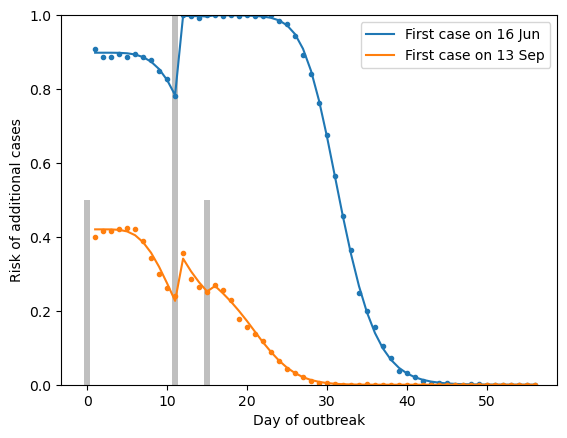

In [6]:
for incidence_vec in [[1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1]]:
    fig, ax = plt.subplots()
    ax.bar(
        np.arange(len(incidence_vec)),
        incidence_vec / np.max(incidence_vec),
        color="gray",
        alpha=0.5,
    )
    for doy_start, color in zip(
        example_doys,
        ["tab:blue", "tab:orange"],
        strict=True,
    ):
        date_start = pd.Timestamp(year=2017, month=1, day=1) + pd.Timedelta(
            days=doy_start - 1
        )
        eop_days = np.arange(1, len(incidence_vec) + len(gen_time_dist_vec) + 1)
        eop_vals = eop_analytical(
            incidence_vec=incidence_vec,
            rep_no_func=lambda t: rep_no_func_doy(doy_start + t),
            gen_time_dist_vec=gen_time_dist_vec,
            t_calc=eop_days,
        )
        ax.plot(
            eop_days,
            1 - eop_vals,
            label=f"First case on {date_start.day} {date_start:%b}",
            color=color,
        )
        eop_days_sim = np.arange(1, len(incidence_vec) + len(gen_time_dist_vec) + 1)
        eop_vals_sim = eop_simulation(
            incidence_vec=incidence_vec,
            rep_no_func=lambda t: rep_no_func_doy(doy_start + t),
            gen_time_dist_vec=gen_time_dist_vec,
            t_calc=eop_days_sim,
            n_sims=1000,
            rng=rng,
        )
        ax.plot(eop_days_sim, 1 - eop_vals_sim, ".", color=color)
        ax.set_ylim(0, 1)
        ax.set_xlabel("Day of outbreak")
        ax.set_ylabel("Risk of additional cases")
        ax.legend()

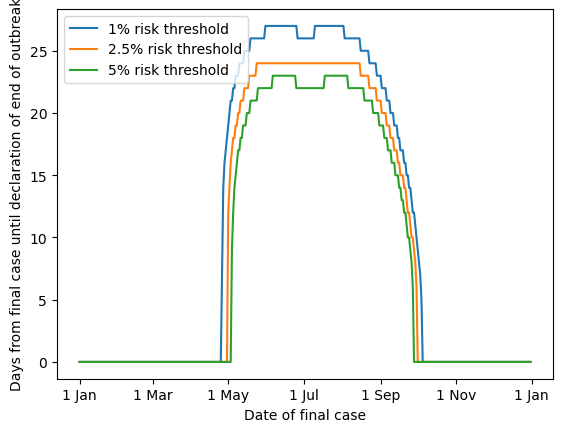

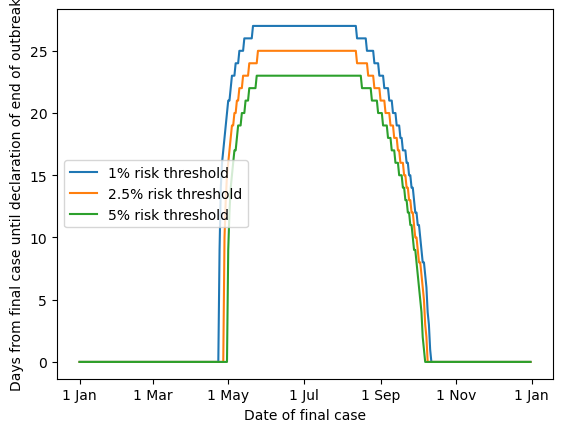

In [7]:
incidence_vec = [1]
perc_risk_thresholds = [1, 2.5, 5]

for incidence_vec in [[1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1]]:
    fig, ax = plt.subplots()

    for perc_risk_threshold in perc_risk_thresholds:
        doy_vec = np.arange(1, 366)
        declaration_day_vec = np.zeros(365)
        for doy_last_case in doy_vec:
            doy_start = doy_last_case - len(incidence_vec) + 1
            eop_days = np.arange(
                len(incidence_vec), len(incidence_vec) + len(gen_time_dist_vec) + 1
            )
            eop_vals = eop_analytical(
                incidence_vec=incidence_vec,
                rep_no_func=lambda t: rep_no_func_doy(doy_start + t),
                gen_time_dist_vec=gen_time_dist_vec,
                t_calc=eop_days,
            )
            declaration_day = np.where(1 - eop_vals < perc_risk_threshold / 100)[0][0]
            declaration_day_vec[doy_last_case - 1] = declaration_day
        ax.plot(
            doy_vec, declaration_day_vec, label=f"{perc_risk_threshold}% risk threshold"
        )
    month_start_xticks(ax)
    ax.set_xlabel("Date of final case")
    ax.set_ylabel("Days from final case until declaration of end of outbreak")
    ax.legend()

In [28]:
no_sims = 5000
outbreak_size_threshold = 2
perc_risk_threshold = 5
doy_start_vec = np.zeros(no_sims, dtype=int)
doy_last_case_vec = np.zeros(no_sims, dtype=int)
declaration_day_vec = np.zeros(no_sims, dtype=int)
for sim_idx in tqdm(range(no_sims)):
    outbreak_found = False
    while not outbreak_found:
        doy_start = rng.integers(90, 275)
        rep_no_func = lambda t: rep_no_func_doy(doy_start + t)
        incidence_vec = renewal_model(
            rep_no_func=rep_no_func,
            t_stop=1000,
            gen_time_dist_vec=gen_time_dist_vec,
            rng=rng,
            incidence_init=1,
        )
        if np.sum(incidence_vec) >= outbreak_size_threshold:
            outbreak_found = True
    time_last_case = incidence_vec.nonzero()[0][-1]
    doy_last_case = doy_start + time_last_case
    eop_days = np.arange(
        time_last_case + 1, time_last_case + len(gen_time_dist_vec) + 2
    )
    eop_vals = eop_analytical(
        incidence_vec=incidence_vec,
        rep_no_func=rep_no_func,
        gen_time_dist_vec=gen_time_dist_vec,
        t_calc=eop_days,
    )
    declaration_day = np.where(1 - eop_vals < perc_risk_threshold / 100)[0][0]
    doy_start_vec[sim_idx] = doy_start
    doy_last_case_vec[sim_idx] = doy_last_case
    declaration_day_vec[sim_idx] = declaration_day
    if doy_last_case < 250 and declaration_day == 0:
        print("Oh no!")


100%|██████████| 5000/5000 [00:27<00:00, 183.72it/s]


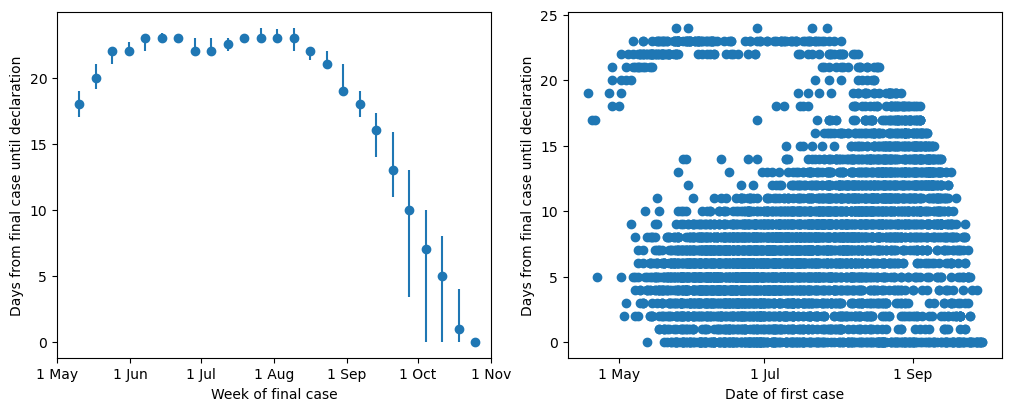

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
df = pd.DataFrame({"doy": doy_last_case_vec, "decl": declaration_day_vec})
bin_width = 7
df["doy_bin"] = pd.cut(
    df["doy"], bins=range(1, 366, bin_width), right=False, include_lowest=True
)
stats = (
    df.groupby("doy_bin", observed=True)["decl"].quantile([0.025, 0.5, 0.975]).unstack()
)
bin_centers = [interval.mid for interval in stats.index]
ax1.errorbar(
    bin_centers,
    stats[0.5],
    yerr=[
        stats[0.5] - stats[0.025],
        stats[0.975] - stats[0.5],
    ],
    fmt="o",
)
ax1.set_xlabel("Week of final case")
ax1.set_ylabel("Days from final case until declaration")
ax1.set_xlim(121, 305)
month_start_xticks(ax1, interval_months=1)
ax2.scatter(
    doy_start_vec,
    declaration_day_vec,
)
ax2.set_xlabel("Date of first case")
ax2.set_ylabel("Days from final case until declaration")
month_start_xticks(ax2)

Text(0, 0.5, 'Time-dependent reproduction number')

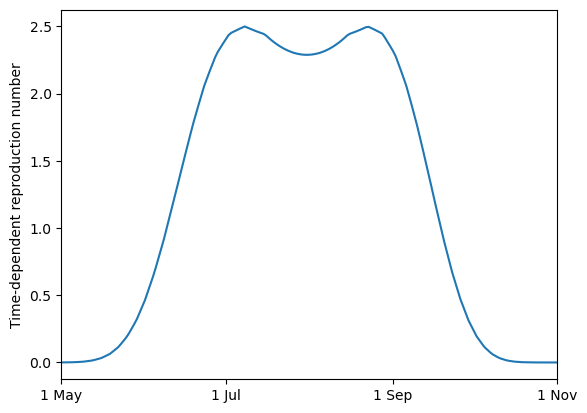

In [34]:
fig, ax = plt.subplots()
doy_vec = np.arange(121, 306)
ax.plot(doy_vec, rep_no_func_doy(doy_vec))
ax.set_xlim(121, 305)
month_start_xticks(ax)
ax.set_ylabel("Time-dependent reproduction number")